# Ritz approximation and dissipative barrier methods for a Sturm-Liouville operator

In this notebook we will aim to compare a dissipative barrier method against the high-accuracy
eigenvalue calculation method outlined in [1] for finding the eigenvalues of the
Sturm-Liouville operator

$$Ly = -y'' + Q(x)y$$

where $Q(x) = \sin(x) - \frac{40}{1+x^2}$.

[1] Aceto, Ghelardoni & Marletta (2006) Numerical computation of eigenvalues in spectral gaps of Sturm–Liouville operators, Journal of Computational and Applied Mathematics

In [1]:
from typing import Dict

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from specpol.ritz import sturm_liouville_bdd, sturm_liouville_halfline
from specpol.plot import plot_ritz

In [2]:
def plot(ritz_results: Dict[int, np.array], title="", dbm=None):
    # plot the approximation with some added bars and lines

    fig, ax1, ax2 = plot_ritz(ritz_results, dbm=dbm)
    fig.suptitle(title, fontsize=12)

    ax1.set_ylim(-0.5, 2.5)

    ax1.axhline(-0.2277, linestyle="--", alpha=0.6, color='#ad5151')

    ax1.axhline(0.335936534279424, linestyle="--", alpha=0.6)
    ax1.axhline(0.536620364148446, linestyle="--", alpha=0.6)
    ax1.axhline(0.580834838005921, linestyle="--", alpha=0.6)
    ax1.axhline(0.591500609480355, linestyle="--", alpha=0.6)

    ax1.axhline(0.949634991713441, linestyle="--", alpha=0.6)
    ax1.axhline(1.24466406161563, linestyle="--", alpha=0.6)
    ax1.axhline(1.29192807845892, linestyle="--", alpha=0.6)

    ax1.axhspan(-0.3784, -0.34766, facecolor="green", alpha=0.2)
    ax1.axhspan(0.594799, 0.9180581788, facecolor="green", alpha=0.2)
    ax1.axhspan(1.2931662851, 2.2851569481, facecolor="green", alpha=0.2)

    ax2.set_xlim(-0.5, 1.5)
    ax2.set_ylim(-0.5, 1.25)

    ax2.axvline(-0.2277, linestyle="--", alpha=0.6, color='#ad5151')

    ax2.axvline(0.335936534279424, linestyle="--", alpha=0.6)
    ax2.axvline(0.536620364148446, linestyle="--", alpha=0.6)
    ax2.axvline(0.580834838005921, linestyle="--", alpha=0.6)
    ax2.axvline(0.591500609480355, linestyle="--", alpha=0.6)

    ax2.axvline(0.949634991713441, linestyle="--", alpha=0.6)
    ax2.axvline(1.24466406161563, linestyle="--", alpha=0.6)
    ax2.axvline(1.29192807845892, linestyle="--", alpha=0.6)

    ax2.axvspan(-0.3784, -0.34766, facecolor="green", alpha=0.2)
    ax2.axvspan(0.594799, 0.9180581788, facecolor="green", alpha=0.2)
    ax2.axvspan(1.2931662851, 2.2851569481, facecolor="green", alpha=0.2)

    plt.show()

In [3]:
def potential(x):  # the potential Q(x) of the Sturm-Liouville operator
    return np.sin(x)# - 40/(1+x**2)

In [5]:
sl_spec = dict()
sl_spec_dbm = dict()

for i in tqdm(np.linspace(0, 1, 25)):
    sl_spec_dbm[i] = sturm_liouville_bdd(potential, (0, 70 * np.pi), 150, 321, (np.pi/8, np.pi/2), dbm=(lambda x: i*(x<=150)))

100%|██████████| 8/8 [03:54<00:00, 29.26s/it]


In [ ]:
plot(sl_spec_dbm, title="Truncated Galerkin approximation of Sturm-Liouville operator, dissipative barrier applied")

In [4]:
rusl = {}
for i in tqdm(range(50, 121, 10)):
    rusl[i] = sturm_liouville_halfline(potential, i, 250, alpha=np.pi/8, dbm=(lambda x: (x<=100)))

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [01:52<00:00, 14.10s/it]


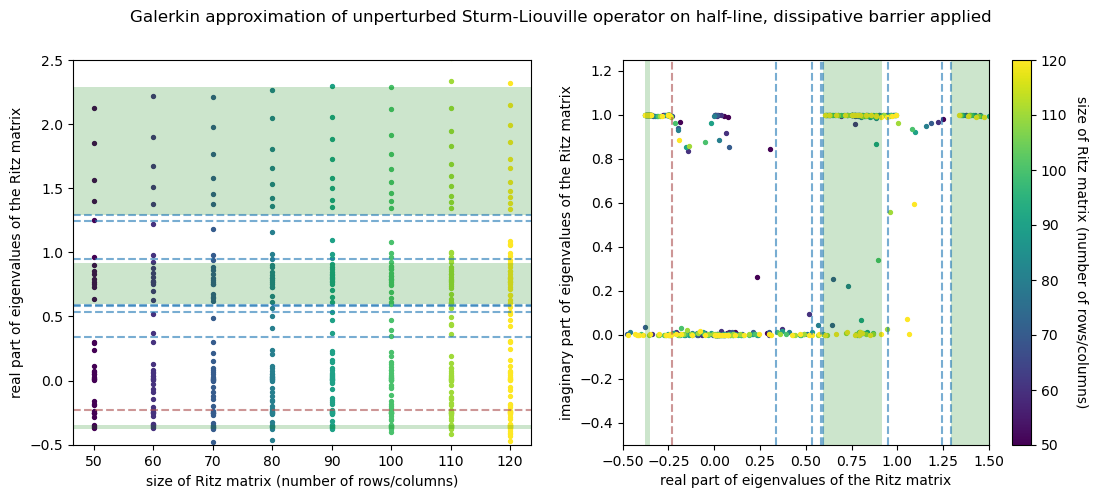

In [5]:
plot(rusl, title="Galerkin approximation of unperturbed Sturm-Liouville operator on half-line, dissipative barrier applied")

In [ ]:
rusl_dbm = {}
for i in tqdm(np.linspace(0, 1, 25)):
    rusl_dbm[i] = sturm_liouville_halfline(potential, 120, 250, alpha=np.pi/8, dbm=(lambda x: i*(x<=100)))
plot(rusl_dbm, title="Galerkin approximation of Sturm-Liouville operator on half-line, dissipative barrier applied")

In [7]:
rusl_eigpairs = sturm_liouville_halfline(potential, 120, 250, alpha=np.pi/8, dbm=(lambda x: x<=100), returns='vectors')

In [49]:
from specpol.common import laguerre, lagdiff
import scipy.integrate as spint
import mpmath as mp

def disc_eigfunc(vec):
    return lambda x: sum(weight * mp.laguerre(i, 0, x) * np.exp(-x/2) for i, weight in enumerate(vec, start=0))

def delta_eigfunc(vec):
    def eigfunc(x):
        return sum(
            weight * np.exp(-x/2)
                   * (mp.laguerre(i-2, 2, x)
                      - mp.laguerre(i-1, 1, x)
                      + 1/4 * mp.laguerre(i, 0, x))
                for i, weight in enumerate(vec, start=0))
    return eigfunc

def residual(vec, lda):
    eigfn = disc_eigfunc(vec)
    eigdf = delta_eigfunc(vec)

    norm = spint.quad(lambda x: np.abs(eigfn(x))**2, 0, 200, limit=500, epsabs=1e-11, epsrel=1e-29)[0]

    def lu(x):
        return np.abs((-eigdf(x) + (potential(x) - lda) * eigfn(x)) / norm)**2

    plt.plot(np.linspace(0, 500, 1500), [complex(lu(x)).real for x in np.linspace(0, 500, 1500)])
    plt.show()

    res = spint.quad(lu, 1, 200, limit=500, epsabs=1e-11, epsrel=1e-29)[0]
    return res**(1/2)

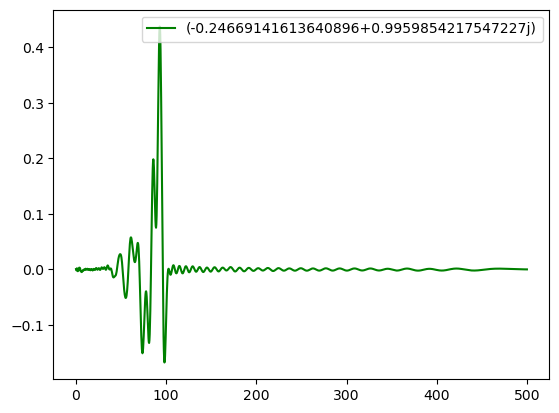

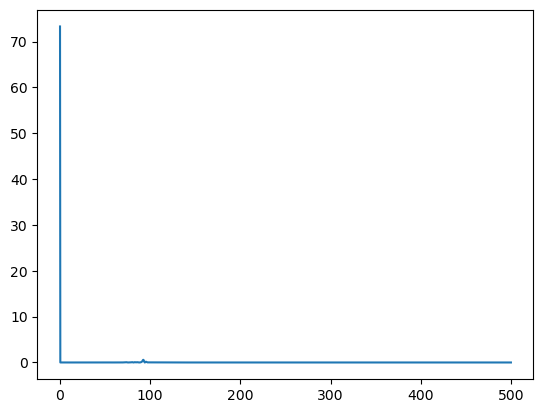

1.461000984176099

In [50]:
special_vals = rusl_eigpairs.filter(lambda x: x.real < -0.22 and x.real > -0.25 and x.imag > 0.95)

myval, myvec = list(special_vals.data.items())[0]
eigfn = disc_eigfunc(myvec)
plt.plot(np.linspace(0, 500, 1500), [complex(eigfn(x)).real for x in np.linspace(0, 500, 1500)], label=f'{myval}', color='green')
plt.legend()
plt.show()

residual(myvec.real, myval.real)

In [44]:
eigdf = delta_eigfunc(myvec.real)
mp.mp.prec= 500


mpf('1.0')

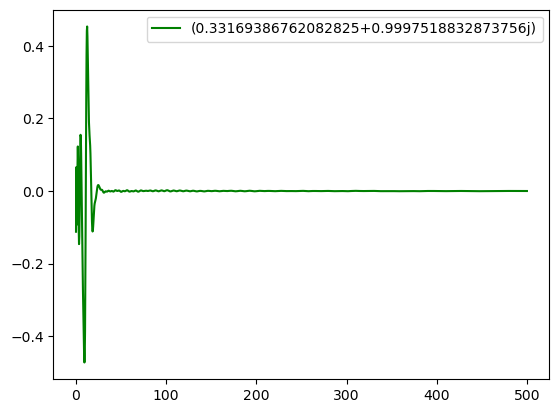

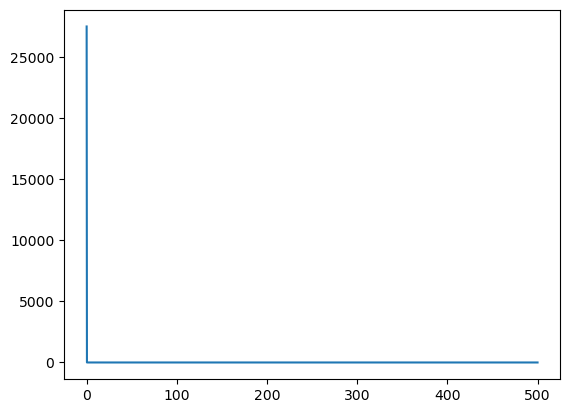

18.360555719098173

In [124]:
safe_val = rusl_eigpairs.filter(lambda x: x.real < 0.5 and x.real > 0.25 and x.imag > 0.95)
sval, svec = list(safe_val.data.items())[0]
eigfn = disc_eigfunc(svec)
plt.plot(np.linspace(0, 500, 1500), [complex(eigfn(x)).real for x in np.linspace(0, 500, 1500)], label=f'{sval}', color='green')
plt.legend()
plt.show()

residual(svec.real, sval.real)

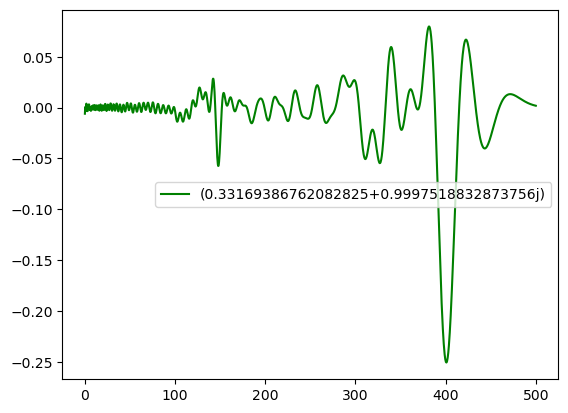

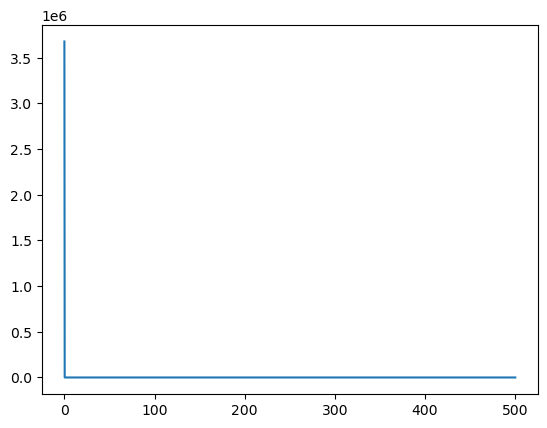

/tmp/ipykernel_5799/2151862035.py:30: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res = spint.quad(lu, 0, 200, limit=500, epsabs=1e-11, epsrel=1e-29)[0]


197.2244657639962

In [125]:
poll_val = rusl_eigpairs.filter(lambda x: x.real < 0.25 and x.real > 0)
pval, pvec = list(poll_val.data.items())[0]
eigfn = disc_eigfunc(pvec)
plt.plot(np.linspace(0, 500, 1500), [complex(eigfn(x)).real for x in np.linspace(0, 500, 1500)], label=f'{sval}', color='green')
plt.legend()
plt.show()

residual(pvec.real, pval.real)